# Rapport de laboratoire 2
Hugo Fournier, 2011296

## Question 1
### 1. Implémentation de la méthode modifiée

In [131]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf, LDLFactorizations, Plots

In [86]:
function bfgs_quasi_newton_quadratique_convexe(A, b, x0; verbose::Bool = true, eps::Float64 = 1e-6)
  start_timer = time()
  x_history = zeros(size(x0))

  f(x) = -b'*x + (1/2)*x'*A*x
  nlp = ADNLPModel(f, x0)
  xk = x0
  fk = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  continue_eval = true
  H0 = I
  sk = xk
  yk = gk
  Hk = H0
  while continue_eval
    if k == 0
      Hk = H0
    elseif yk'*sk > 0
      Hk = (k==1 ? I *(yk'*sk) / (yk'*yk) : Hk)
      pk = 1 / (yk'*sk)
      Hk = (I - pk*sk*yk') * Hk * (I - pk*yk*sk') + pk*sk*sk'
    end
    dk = -Hk * gk
    t = -(gk' * dk) / (dk' * A * dk)
    sk = t * dk
    yk = grad(nlp, xk + sk) - gk
    xk += sk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    if gnorm <= eps + eps * gnorm0
      # Solution found
      continue_eval = false
    elseif neval_obj(nlp) > 1000
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Evaluations (1000) of Objective Function \n"
    elseif time() - start_timer > 60.0
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Time of Method (60.0s) \n"
    elseif fk < -1e15
      continue_eval = false
      @printf "\nMETHOD FAILED - Objective Function is not Bounded (fk < -1e15) \n"
    elseif k >= 100
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Iterations (100) \n"
    end
  end
  verbose && @printf "\nElapsed Time : %.2f ms\n" (time() - start_timer) * 1000
  return xk
end

bfgs_quasi_newton_quadratique_convexe (generic function with 1 method)

### 2. Test de la méthode modifiée

In [213]:
#Test
n = 10;
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1));
b = A * [1:n;];
x0 = zeros(n);

res = bfgs_quasi_newton_quadratique_convexe(A, b, x0; verbose=true, eps=1e-10)

 k        fk ||∇f(x)||
 0  0.00e+00   1.1e+02
 1 -1.09e+03   6.6e+00 1.7e-01 
 2 -1.10e+03   1.4e+00 1.3e+00 
 3 -1.10e+03   3.5e-01 1.5e+00 
 4 -1.10e+03   9.2e-02 1.6e+00 
 5 -1.10e+03   2.4e-02 1.6e+00 
 6 -1.10e+03   6.2e-03 1.6e+00 
 7 -1.10e+03   1.6e-03 1.6e+00 
 8 -1.10e+03   3.7e-04 1.6e+00 
 9 -1.10e+03   7.1e-05 1.7e+00 
10 -1.10e+03   3.4e-14 2.1e+00 

Elapsed Time : 3.00 ms


10-element Vector{Float64}:
  1.0
  2.0000000000000004
  2.9999999999999987
  4.000000000000001
  4.999999999999997
  6.000000000000001
  6.999999999999994
  8.000000000000007
  8.999999999999998
 10.000000000000002

### 3. Raisonnement sur la définition d'alpha
Par définition, $A$ est symmétrique définie positive. Elle peut donc être décomposée sous une forme $A = Q \Sigma Q^{T}$, ou $\Sigma$ est une matrice diagonale contenant les valeurs propres de $A$ et $Q$ est une matrice orthogonale.
Par conséquent, $$d^{T}A d = d^{T} Q \Sigma Q^{T} d = u^{T} \Sigma u$$ avec $u = Q^{T} d$.
Comme toutes les valeurs propres de $A$ contenues dans $\Sigma$ sont strictement positives, $$u^{T} \Sigma u = \sum_{i = 1}^{\text{rank}(A)} \lambda_{i} u_{i}^{2} > 0 \text{, si rank}(A) > 0 \text{ et } u \neq 0$$

## Question 2

In [300]:
function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

# Implémentation de la méthode BFGS Newton-Armijo avec un renvoi de l'historique de xk
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true, eps::Float64 = 1e-6)
  start_timer = time()
  x_history = Vector{Vector{Float64}}()
  xk = x0
  fk = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  continue_eval = true
  H0 = I
  sk = xk
  yk = gk
  Hk = H0
  while continue_eval
    if k == 0
      Hk = H0
    elseif yk'*sk > 0
      Hk = (k==1 ? I *(yk'*sk) / (yk'*yk) : Hk)
      pk = 1 / (yk'*sk)
      Hk = (I - pk*sk*yk') * Hk * (I - pk*yk*sk') + pk*sk*sk'
    end
    dk = -Hk * gk
    t = armijo(xk, dk, fk, gk, x->obj(nlp, x))
    sk = t * dk
    yk = grad(nlp, xk + sk) - gk
    xk += sk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    push!(x_history, xk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    if gnorm <= eps + eps * gnorm0
      # Solution found
      continue_eval = false
    elseif neval_obj(nlp) > 1000
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Evaluations (1000) of Objective Function \n"
    elseif time() - start_timer > 60.0
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Time of Method (60.0s) \n"
    elseif fk < -1e15
      continue_eval = false
      @printf "\nMETHOD FAILED - Objective Function is not Bounded (fk < -1e15) \n"
    elseif k >= 100
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Iterations (100) \n"
    end
  end
  return xk, x_history
end

# Implémentation de la méthode Newton-Armijo avec un renvoi de l'historique de xk
function newton_armijo(nlp, x0; verbose::Bool = true, eps::Float64 = 1e-6)
  start_timer = time()
  x_history = Vector{Vector{Float64}}()
  xk = x0
  fk = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  continue_eval = true
  while continue_eval
    Hk = hess(nlp, xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    λ_counter = 0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && λ_counter < 5
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
      λ_counter += 1
      if λ_counter == 5 && slope ≥ -1.0e-4 * norm(dk) * gnorm
        dk = -gk
      end
    end
    t = armijo(xk, dk, fk, gk, x->obj(nlp, x))
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    push!(x_history, xk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    if gnorm <= eps + eps * gnorm0
      # Solution found
      continue_eval = false
    elseif neval_obj(nlp) > 1000
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Evaluations (1000) of Objective Function \n"
    elseif time() - start_timer > 60.0
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Time of Method (60.0s) \n"
    elseif fk < -1e15
      continue_eval = false
      @printf "\nMETHOD FAILED - Objective Function is not Bounded (fk < -1e15) \n"
    elseif k >= 100
      continue_eval = false
      @printf "\nMETHOD FAILED - Reached Maximum Number of Iterations (100) \n"
    end
  end
  return xk, x_history
end


function graph_solution(xk_history)
  N = size(xk_history)[1]
  n = N - 1;
  x = zeros(n);
  y = zeros(n);
  for i=1:n
    x[i] = i;
    y[i] = norm(xk_history[i] - xk_history[N]);
  end
  p = plot(x, y, xlabel="k", label="fH");
  return p
end

function graph_convergence_lineaire(xk_history)
  N = size(xk_history)[1]
  n = N - 2;
  x = zeros(n);
  y = zeros(n);
  for i=1:n
    x[i] = i;
    y[i] = norm(xk_history[i + 1] - xk_history[N]) / norm(xk_history[i] - xk_history[N]);
  end
  p = plot(x, y, xlabel="k", label="fH");
  return p
end

function graph_convergence_quadratique(xk_history)
  N = size(xk_history)[1]
  n = N - 2;
  x = zeros(n);
  y = zeros(n);
  for i=1:n
    x[i] = i;
    y[i] = norm(xk_history[i + 1] - xk_history[N]) / (norm(xk_history[i] - xk_history[N])^2);
  end
  p = plot(x, y, xlabel="k", label="fH");
  return p
end


graph_convergence_quadratique (generic function with 1 method)

In [325]:
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2;           # Définition de la fonction fH(x)
xH0 = (rand(2) - 0.5 * ones(2)) * 100;                      # Choix d'un point de départ aléatoire dans l'intervalle l=[-50, -50] et u=[50, 50]
nlpH = ADNLPModel(fH, xH0);                                 # Construction du modèle ADNLP

res_1, xk_history_1 = bfgs_quasi_newton_armijo(nlpH, xH0; verbose=false, eps=1e-15);
res_2, xk_history_2 = newton_armijo(nlpH, xH0; verbose=false, eps=1e-15);

p1_1 = graph_solution(xk_history_1);                            # Production du graphique de la solution
p1_2 = graph_solution(xk_history_2);                            # Production du graphique de la solution
p2_1 = graph_convergence_lineaire(xk_history_1);                # Production du graphique de la convergence linéraire
p2_2 = graph_convergence_lineaire(xk_history_2);                # Production du graphique de la convergence linéraire
p3_1 = graph_convergence_quadratique(xk_history_1);             # Production du graphique de la convergence quadratique
p3_2 = graph_convergence_quadratique(xk_history_2);             # Production du graphique de la convergence quadratique

# Affichage des graphiques
p1 = plot(plot!(p1_1, title="BFGS", yscale=(:log10)), plot!(p1_2, title="Newton", yscale=(:log10)));
p2 = plot(plot!(p2_1, title="BFGS"), plot!(p2_2, title="Newton"));
p3 = plot(plot!(p3_1, title="BFGS", yscale=(:log10)), plot!(p3_2, title="Newton", yscale=(:log10)));

# Voici les 4 minimums locaux obtenus à partir de différents xH0
#  3.00,  2.00
# -2.80,  3.13
#  3.58, -1.84
# -3.78, -3.28

@printf "Point de départ   : [%.2f, %.2f] \n" xH0[1] xH0[2]
@printf "Résultat BFGS     : [%.2f, %.2f] \n" res_1[1] res_1[2]
@printf "Résultat Newton   : [%.2f, %.2f] \n" res_2[1] res_2[2]

# Notons que les deux méthodes ne convergent pas nécessairement vers la même solution, dépendamment du point de départ.

Point de départ   : [-39.77, 24.68] 
Résultat BFGS     : [3.00, 2.00] 
Résultat Newton   : [-2.81, 3.13] 


### Évolution de la solution

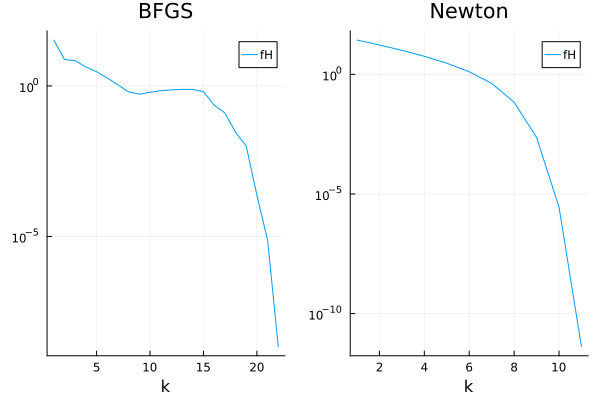

In [326]:
display(p1);

### Convergence linéaire
Pour les deux méthodes, on observe qu'après un certain nombre d'itérations, la convergence linéaire plonge vers 0. Cependant, la méthode BFGS présente un comportement beaucoup plus chaotique que Newton.
Il s'agit du comportement attendu.

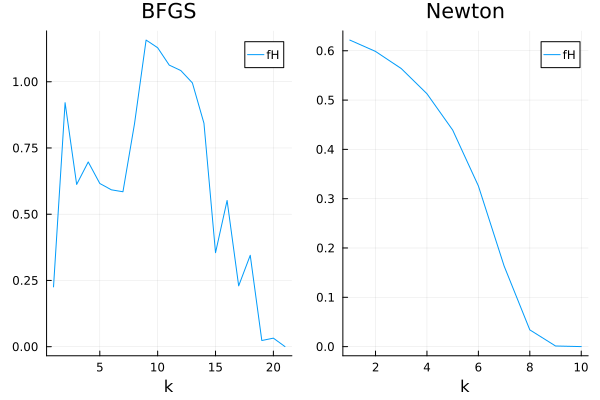

In [327]:
display(p2);

### Convergence quadratique
Dans le cas de la méthode Newton, on observe que le facteur de convergence quadratique se stabilise vers une constante près de 1. Il s'agit du résultat attendu, puisque cette méthode possède en théorie une convergence quadratique.
Concernant la méthode BFGS, il y a une absence de stabilité du facteur de convergence quadratique, ce qui est attendu.

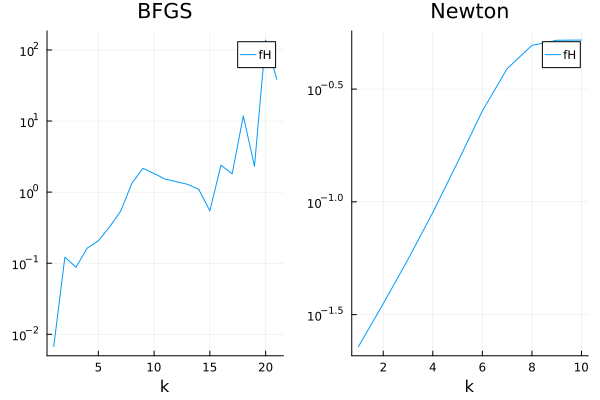

In [328]:
display(p3);

## Question 3
### 1. Problème choisi : 208
### 2. Modélisation JuMP du problème choisi

In [258]:
using JuMP, Ipopt

function probleme_208_JuMP()
    model = Model(Ipopt.Optimizer)
    @variable(model, x[i=1:2])
    @NLobjective(model, Min, 100 * (x[2] - x[1]^2)^2 + (1 - x[1])^2)
    return model
end

probleme_208_JuMP (generic function with 1 method)

### 3. Modèle ADNPLModel du problème choisi

In [257]:
using ADNLPModels

function probleme_208_ADNLP()
    f(x) = 100 * (x[2] - x[1]^2)^2 + (1 - x[1])^2;
    x0 = [-1.2; 1.0];
    nlp = ADNLPModel(f, x0);
    return nlp
end

probleme_208_ADNLP (generic function with 1 method)